In [1]:
from pyomo.environ import *
import numpy as np
import matplotlib.pyplot as plt
import bisect
from pyomo.opt import SolverStatus, TerminationCondition

In [13]:
def evaluate_Q_at(model, y_val, solver):
    """
    Given y = y_val , minimize obj_expr and return v(y).
    This function temporarily increments the objective and clears it after completion, without changing the model structure.
    """
    # Clear any remaining As/pw/obj (to prevent it from being left over from the previous round)
    for comp in ['obj', 'As', 'pw']:
        if hasattr(model, comp):
            model.del_component(comp)

    # Fix y, create a temporary target and solve
    model.y.fix(y_val)
    model.obj = Objective(expr=model.obj_expr, sense=minimize)
    results = solver.solve(model, tee=False)

    status_ok = (results.solver.status == SolverStatus.ok)
    term_ok = (results.solver.termination_condition == TerminationCondition.optimal)
    if not (status_ok and term_ok):
        # check if solution okay
        raise RuntimeError(f"Scenario evaluate at y={y_val} not optimal: "
                           f"status={results.solver.status}, term={results.solver.termination_condition}")

    v_y = value(model.obj_expr)
    # clear temporarily objective
    model.del_component('obj')
    model.y.unfix()
    return v_y

def nc_underest(bounds, model_list, add_node_num, tolerance=1e-8):
    """
    Parameters:
        bounds (list): contains 2 float which is lower and upper bound of variable
        model (list): model with submodels corresponds to each scenario
        add_node_num (float): number of sample nodes
        tolerance (float): decide when to stop

    Returns: delta (float): delta
             errors (float): hausdorff error
             y_nodes (list): y node (to make plot)
             as_nodes_list[0] (list): As node value (to make plot)
             ms_list[0] (float): ms for first scenario (to make plot)
    """
    N = len(model_list) 
    new_lb = bounds[0]
    new_ub = bounds[1]
    eff_node_count = 0 #  count how many extra nodes were actually added
    as_nodes_list = [None] * N
    ms_list = [None] * N
    new_nodes_list = [None] * N # Storing potential new nodes
    under_tol = 1e-8

    # set up solver
    solver = SolverFactory('gurobi')
    solver.options['FeasibilityTol'] = 1e-09
    solver.options['OptimalityTol'] = 1e-09
    solver.options['NonConvex'] = 2 
    
    # start with 2 nodes
    #y_nodes = bounds
    y_nodes = [bounds[0],bounds[1]]
    print('##################################################')
    print('##################################################')
    for i in range(N):
        as_nodes_list[i] = [evaluate_Q_at(model_list[i], new_lb, solver),evaluate_Q_at(model_list[i], new_ub, solver)]
    # reset bounds
    for i in range(N):
        model_list[i].y.setlb(new_lb)
        model_list[i].y.setub(new_ub)
    
    print('The goal is to get ',add_node_num,' nodes')
    for k in range(3,add_node_num+1):
        print('Start adding node ',k)
        for i in range(N):
            print('Solving scenario ',i)
            # define piecewise function for each scenario
            for comp in ['obj', 'As', 'pw']:
                if hasattr(model_list[i], comp):
                    model_list[i].del_component(comp)
            model_list[i].As = Var()
            model_list[i].pw = Piecewise(
                model_list[i].As, model_list[i].y,
                pw_pts=y_nodes,
                f_rule=as_nodes_list[i],
                pw_constr_type='EQ',
                pw_repn='SOS2'
            )

            # set up objective for each scenario and solve
            model_list[i].obj = Objective(expr=model_list[i].obj_expr - model_list[i].As, sense=minimize)
            results = solver.solve(model_list[i])
            
            if (results.solver.status != SolverStatus.ok) or \
               (results.solver.termination_condition != TerminationCondition.optimal):
                print("⚠ There may be problems with the solution")
                
            ms_list[i] = value(model_list[i].obj)


                
            # insert new nodes
            new_nodes_list[i] = value(model_list[i].y)
            
            
            
        ##################################################
                    
    
        # define and solve the sum model
        arr = np.array(as_nodes_list, dtype=float, ndmin=2)  
        assum_nodes = arr.sum(axis=0)    
        
        model_sum = ConcreteModel()
        model_sum.y = Var(bounds=(new_lb, new_ub))
        model_sum.As = Var()
        model_sum.pw = Piecewise(
            model_sum.As, model_sum.y,
            pw_pts=y_nodes,
            f_rule=list(assum_nodes),
            pw_constr_type='EQ',
            pw_repn='SOS2'
        )
        #eps_local = 1e-6
        #model_sum.obj = Objective(expr = model_sum.As + eps_local*model_sum.y**2, sense=minimize)
        model_sum.obj = Objective(expr = model_sum.As, sense=minimize)
        results = solver.solve(model_sum)
        if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
            pass
        else:
            print("Sum model doesn't get solved normally")
        # get the output
        As_min = results.problem.lower_bound
        y_star = value(model_sum.y, exception=False)   
        if y_star is None:
            y_star = 0.5*(new_lb + new_ub)
        errors_y_star = 0
        for i in range(N):
            errors_y_star += evaluate_Q_at(model_list[i], y_star, solver)
        errors_y_star = abs(As_min - errors_y_star)
        

        '''
        if (k == 2) and (abs(assum_nodes[0] - assum_nodes[1]) <= 1e-12):
            print('PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP')
            y_star = 0.5*(y_nodes[0] + y_nodes[1])
            errors = 0
            for i in range(N):
                errors += evaluate_Q_at(model_list[i], y_star, solver)
            errors = abs(assum_nodes[0] - errors)
            print('LLLLLLLLLLLLLLLLL',assum_nodes[0])
        else:
            print('QQQQQQQQQPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP')
            model_sum = ConcreteModel()
            model_sum.y = Var(bounds=(new_lb, new_ub))
            model_sum.As = Var()
            model_sum.pw = Piecewise(
                model_sum.As, model_sum.y,
                pw_pts=y_nodes,
                f_rule=list(assum_nodes),
                pw_constr_type='EQ',
                pw_repn='SOS2'
            )
            model_sum.obj = Objective(expr = model_sum.As, sense=minimize)
            results = solver.solve(model_sum)
            if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
                pass
            else:
                print("Sum model doesn't get solved normally")
            # get the output
            errors = results.problem.lower_bound + sum(ms_list)
            y_star = value(model_sum.y)
            aaa = 0
            for i in range(N):
                aaa += evaluate_Q_at(model_list[i], y_star, solver)
            errors = abs(aaa - errors)
        '''
        
        sum_ms = abs(sum(ms_i for ms_i in ms_list))
        
        print(' ')
        print(' ')
        print('error is ',errors_y_star)
        print('y_star is ',y_star)
        print('ms is ',ms_list,sum_ms)
        if errors_y_star > sum_ms:
            new_node = y_star
            print(' ')
            print(' ')
            print('new node choosen from error')
            print(' ')
        else:
            min_index = np.argmin(ms_list)
            new_node = new_nodes_list[min_index]
            print(' ')
            print(' ')
            print('new node choosen from ms')
            print(' ')
        print('new node is',new_node)
        #######################################################              


        
        '''
        # check if new node is too close to old nodes         
        if (k == 3):
            last_node = new_node
        else:
            if (abs(new_nodes_list[i] - value(model_list[i].y)) <= 1e-6):
                print("The new node is too close and not inserted")
            break
        '''

        if (new_node not in y_nodes) and (k != add_node_num):
            idx = bisect.bisect_left(y_nodes, new_node)
            y_nodes.insert(idx, new_node)
            for i in range(N):
                as_nodes_list[i].insert(idx, evaluate_Q_at(model_list[i], new_node, solver))
            eff_node_count += 1
            
        print('ms list is',ms_list)
        print('y_nodes is',y_nodes)
                


    # define and solve the sum model
    assum_nodes = np.sum(as_nodes_list, axis=0)
    model_sum = ConcreteModel()
    model_sum.y = Var(bounds=(new_lb, new_ub))
    model_sum.As = Var()
    model_sum.pw = Piecewise(
        model_sum.As, model_sum.y,
        pw_pts=y_nodes,
        f_rule=list(assum_nodes),
        pw_constr_type='EQ',
        pw_repn='SOS2'
    )
    model_sum.obj = Objective(expr = model_sum.As, sense=minimize)
    results = solver.solve(model_sum)
    if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
        pass
    else:
        print("Sum model doesn't get solved normally")
    # get the output
    errors = results.problem.lower_bound + sum(ms_list)
    errors = -errors
    
    # calculate the diameter
    delta = (new_ub-new_lb)/2
    
    #return delta, errors, y_nodes, as_nodes_list[0], ms_list[0], as_nodes_list[1], ms_list[1], eff_node_count, min_index,new_node
    return delta, errors, y_nodes, as_nodes_list[0], ms_list[0], as_nodes_list[1], ms_list[1], eff_node_count,new_node

In [29]:
# build function for each scenario
def v_1(y):  
    return 1.3*y

def v_2(y): 
    return (y-0.5)**2-0.2

v_list = [v_1, v_2]

# lower bound and upper bound
ylb = -0.2
yub = 0.2
# build model for each scenario 
m1 = ConcreteModel()
m1.y = Var(bounds=(ylb, yub))
m1.x1 = Var()
m1.c1 = Constraint(expr=m1.x1 == m1.y)
m1.obj_expr = Expression(expr=1.3*m1.x1)

m2 = ConcreteModel()
m2.y = Var(bounds=(ylb, yub))
m2.x2 = Var()
m2.c1 = Constraint(expr=m2.x2 == (m2.y-0.5)**2)
m2.obj_expr = Expression(expr=m2.x2-0.2)

model_list = [m1, m2]

# make delta list
adds = np.arange(3, 8)
results = [nc_underest([ylb, yub],model_list,a) for a in adds]

##################################################
##################################################
The goal is to get  3  nodes
Start adding node  3
Solving scenario  0
Solving scenario  1
 
 
error is  6.938893903907228e-18
y_star is  -0.2
ms is  [0.0, -0.03999999999999998] 0.03999999999999998
 
 
new node choosen from ms
 
new node is 1.1102230246251565e-16
ms list is [0.0, -0.03999999999999998]
y_nodes is [-0.2, 0.2]
##################################################
##################################################
The goal is to get  4  nodes
Start adding node  3
Solving scenario  0
Solving scenario  1
 
 
error is  6.938893903907228e-18
y_star is  -0.2
ms is  [0.0, -0.03999999999999998] 0.03999999999999998
 
 
new node choosen from ms
 
new node is 1.1102230246251565e-16
ms list is [0.0, -0.03999999999999998]
y_nodes is [-0.2, 1.1102230246251565e-16, 0.2]
Start adding node  4
Solving scenario  0
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive p

   
   
   
y node is  [-0.2  0.2]
y node length 2
ms value is  [0.0, -0.03999999999999998]
new_nodes is  1.1102230246251565e-16
this time choose scenario  0


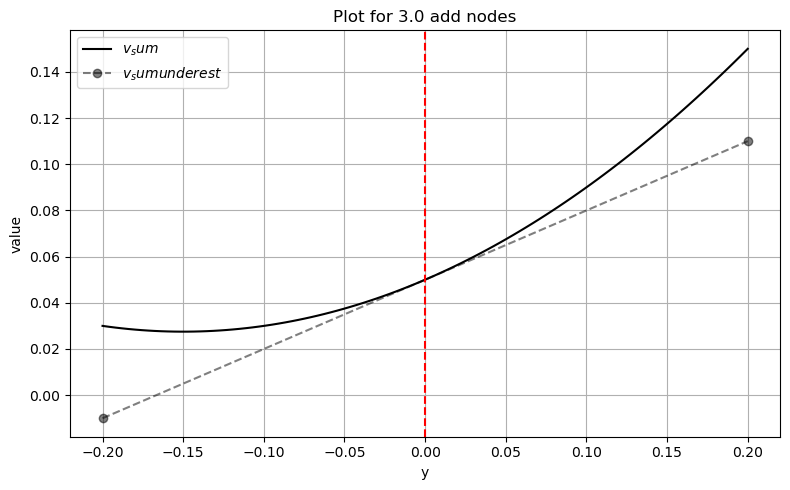

   
   
   
y node is  [-2.00000000e-01  1.11022302e-16  2.00000000e-01]
y node length 3
ms value is  [0.0, -0.009999999999999926]
new_nodes is  -0.1
this time choose scenario  1


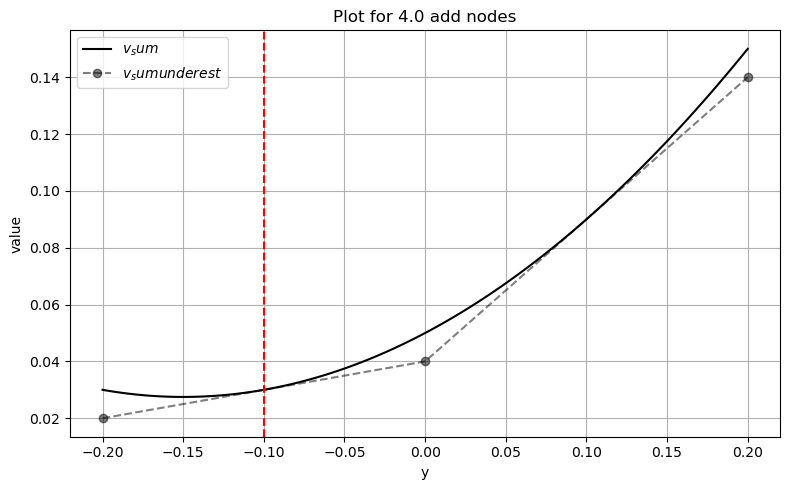

   
   
   
y node is  [-2.00000000e-01 -1.00000000e-01  1.11022302e-16  2.00000000e-01]
y node length 4
ms value is  [0.0, -0.009999999999999936]
new_nodes is  0.1
this time choose scenario  2


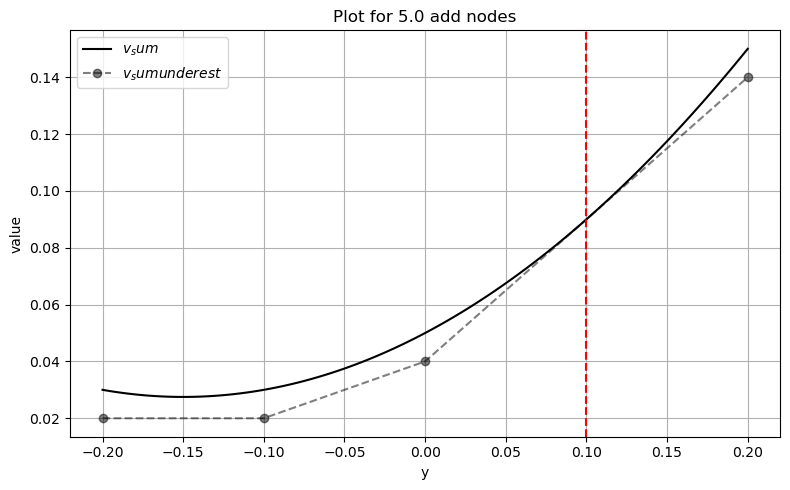

   
   
   
y node is  [-2.00000000e-01 -1.00000000e-01  1.11022302e-16  1.00000000e-01
  2.00000000e-01]
y node length 5
ms value is  [0.0, -0.0024999999999999467]
new_nodes is  -0.15
this time choose scenario  3


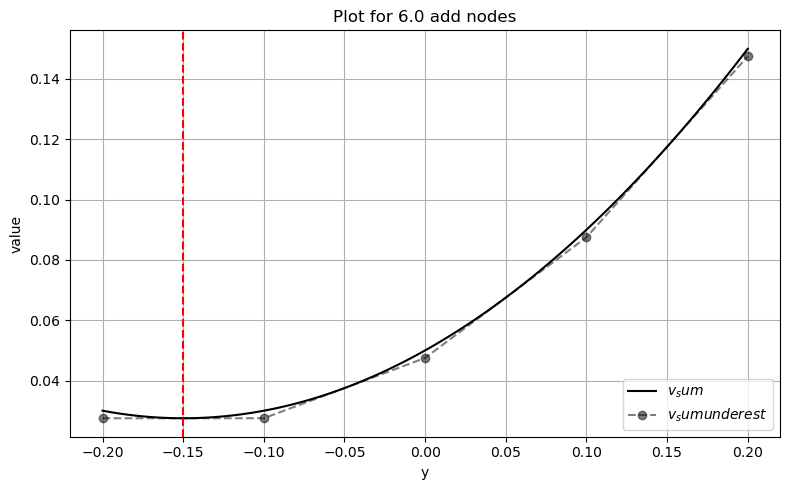

   
   
   
y node is  [-2.00000000e-01 -1.50000000e-01 -1.00000000e-01  1.11022302e-16
  1.00000000e-01  2.00000000e-01]
y node length 6
ms value is  [0.0, -0.0024999999999999745]
new_nodes is  0.05
this time choose scenario  4


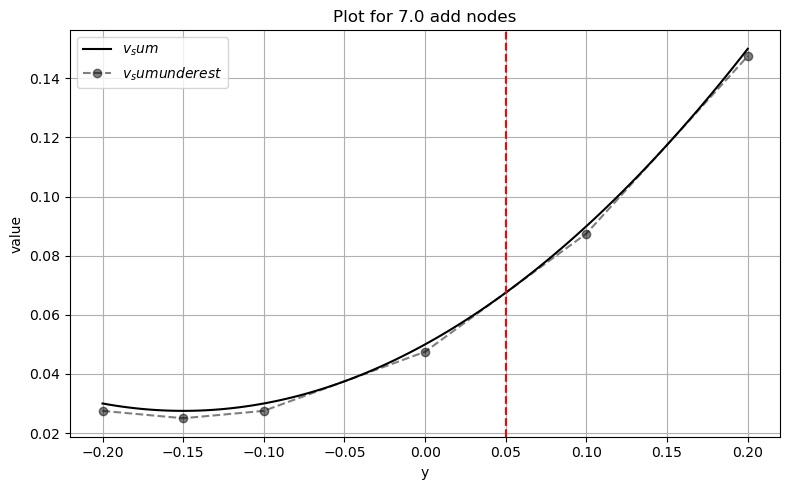

In [30]:
for i in range(len(results)):
    # y and z = |y|
    y_vals = np.linspace(ylb, yub, 100)
    Qs_vals1 = [v_list[0](y) for y in y_vals]
    Qs_vals2 = [v_list[1](y) for y in y_vals]
    Qs_vals_sum = [v_list[0](y)+v_list[1](y) for y in y_vals]

    # As(y)
    y_nodes = np.array(results[i][2])
    as_nodes1 = np.array(results[i][3])
    as_nodes2 = np.array(results[i][5])
    bbb1 = np.array(as_nodes1)
    bbb2 = np.array(as_nodes2)
    bbb_sum = bbb1+bbb2
    ms1 = results[i][4]
    ms2 = results[i][6]
    #err = -results[i][1]
    err = ms1+ms2
    
    print("   ")
    print("   ")
    print("   ")
    #print('effective add node num ',results[i][-2])
    print('y node is ',y_nodes)
    print('y node length',len(y_nodes))
    print("ms value is ",[results[i][4],results[i][6]])
    print("new_nodes is ",results[i][-1])
    print("this time choose scenario ",results[i][-2])

    # make the plot
    
    plt.figure(figsize=(8, 5))
    '''
    plt.plot(y_vals, Qs_vals1, label=r'$v1$', color='red')
    plt.plot(y_nodes, bbb1+ms1,label=r'$v1 underest$',color='red', marker='o',linestyle='--',alpha=0.5)
    plt.plot(y_nodes, bbb1,label=r'$v1 underest$',color='blue', marker='o',linestyle='--',alpha=0.5)
    
    
    plt.plot(y_vals, Qs_vals2, label=r'$v2$', color='blue')
    plt.plot(y_nodes, bbb2+ms2,label=r'$v2 underest$',color='blue', marker='o',linestyle='--',alpha=0.5)
    '''
    plt.plot(y_vals, Qs_vals_sum, label=r'$v_sum$', color='black')
    plt.plot(y_nodes, bbb_sum+err,label=r'$v_sum underest$',color='black', marker='o',linestyle='--',alpha=0.5)
    
    plt.axvline(x=results[i][-1], color='red', linestyle='--')
    #plt.hlines(y=mmm, xmin=ylb, xmax=yub,color='red', linestyle='--')
    
    #plt.xlim(0.05, 0.125)
    #plt.ylim(-0.4, -0.2)
    plt.xlabel('y')
    plt.ylabel('value')
    plt.title(f"Plot for {adds[i]:.1f} add nodes")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.030000000000000047, 4.85722573273506e-17, 0.009999999999999957, 0.0024999999999999675, 0.0024999999999999953]


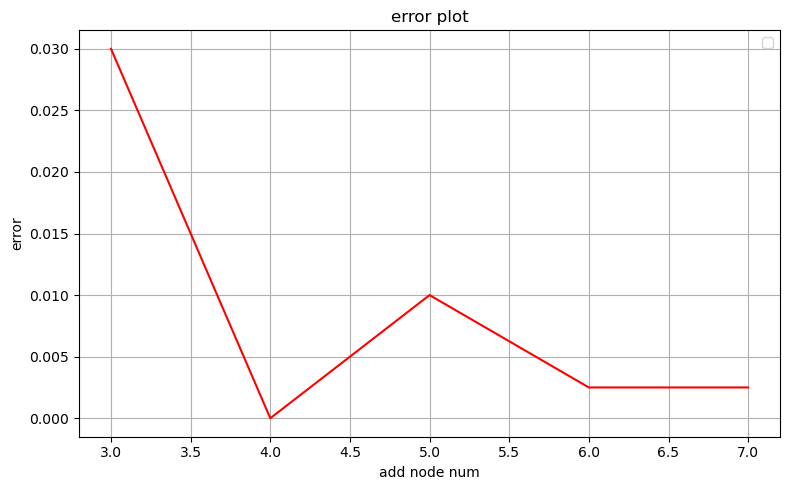

In [27]:
plt.figure(figsize=(8, 5))
mmm = 0.04
errors = [item[1]+mmm for item in results]
plt.plot(adds, errors, color='red')

plt.xlabel('add node num')
plt.ylabel('error')
plt.title(f"error plot")
plt.legend()
plt.grid(True)
plt.tight_layout()

print(errors)

In [75]:
m = ConcreteModel()
m.y = Var(bounds=(0, 1))
m.x1 = Var(bounds=(0, 1))
m.x11 = Var(bounds=(0, None))
m.x2 = Var()
m.c1 = Constraint(expr=m.x11**2 == m.y**2)
m.c2 = Constraint(expr=m.x11 == (m.x1)**2)
m.c3 = Constraint(expr=m.x2 == -(m.y-1)**2)
m.obj = Objective(expr=-m.x1+m.x2+1, sense=minimize)

In [76]:
solver = SolverFactory('gurobi')
solver.options['FeasibilityTol'] = 1e-9
solver.options['OptimalityTol'] = 1e-9
solver.options['NonConvex'] = 2 

In [77]:
results = solver.solve(m)
mmm = results.problem.lower_bound

In [78]:
mmm

-0.12951651163317207

In [65]:
# build function for each scenario
def v_1(y):  
    return (y**2-1)**2-1/2

def v_2(y): 
    return (y**2-1)**2-1/2
v_list = [v_1, v_2]

# lower bound and upper bound
ylb = -1.5
yub = 1.5
bounds = [ylb, yub]
# build model for each scenario 
m1 = ConcreteModel()
m1.y = Var(bounds=(ylb, yub))
m1.x1 = Var(bounds=(0, None))
m1.c1 = Constraint(expr=m1.x1 == m1.y**2)
m1.obj_expr = Expression(expr=(m1.x1-1)**2-1/2)

m1 = ConcreteModel()
m1.y = Var(bounds=(ylb, yub))
m1.x1 = Var(bounds=(0, None))
m1.c1 = Constraint(expr=m1.x1 == m1.y**2)
m1.obj_expr = Expression(expr=(m1.x1-1)**2-1/2)

model_list = [m1,m1]

In [71]:
# make delta list
adds = np.arange(3, 15)
results = [nc_underest([ylb, yub],model_list,a) for a in adds]

##################################################
##################################################
The goal is to get  3  nodes
Start adding node  3
Solving scenario  0
Solving scenario  1
 
 
error is  4.000000000670134e-08
y_star is  0.2
ms is  [-0.1118033988749895, 0.0] 0.1118033988749895
 
 
new node choosen from ms
 
new node is 0.05
ms list is [-0.1118033988749895, 0.0]
y_nodes is [0, 0.2]
##################################################
##################################################
The goal is to get  4  nodes
Start adding node  3
Solving scenario  0
Solving scenario  1
 
 
error is  4.000000000670134e-08
y_star is  0.2
ms is  [-0.1118033988749895, 0.0] 0.1118033988749895
 
 
new node choosen from ms
 
new node is 0.05
ms list is [-0.1118033988749895, 0.0]
y_nodes is [0, 0.05, 0.2]
Start adding node  4
Solving scenario  0
Solving scenario  1
 
 
error is  2.4999997072505664e-09
y_star is  0.05
ms is  [-0.055901699437494755, 0.0] 0.055901699437494755
 
 
new node choose

Solving scenario  1
 
 
error is  2.4999997072505664e-09
y_star is  0.05
ms is  [-0.055901699437494755, 0.0] 0.055901699437494755
 
 
new node choosen from ms
 
new node is 0.012500000000000004
ms list is [-0.055901699437494755, 0.0]
y_nodes is [0, 0.012500000000000004, 0.05, 0.2]
Start adding node  5
Solving scenario  0
Solving scenario  1
 
 
error is  2.500000012561898e-09
y_star is  0.05
ms is  [-0.02795084971874737, 1.477720307230257e-10] 0.02795084957097534
 
 
new node choosen from ms
 
new node is 0.003125
ms list is [-0.02795084971874737, 1.477720307230257e-10]
y_nodes is [0, 0.003125, 0.012500000000000004, 0.05, 0.2]
Start adding node  6
Solving scenario  0
Solving scenario  1
 
 
error is  2.500000012561898e-09
y_star is  0.05
ms is  [-0.01863379499800427, 1.4234799450285607e-10] 0.018633794855656277
 
 
new node choosen from ms
 
new node is 0.11232219320515047
ms list is [-0.01863379499800427, 1.4234799450285607e-10]
y_nodes is [0, 0.003125, 0.012500000000000004, 0.05, 0.1

Solving scenario  1
 
 
error is  2.500000012561898e-09
y_star is  0.05
ms is  [-0.005566325224371449, 1.1102230246251565e-16] 0.005566325224371338
 
 
new node choosen from ms
 
new node is 0.07804604580240435
ms list is [-0.005566325224371449, 1.1102230246251565e-16]
y_nodes is [0, 0.00019531250000000004, 0.0007812500000000002, 0.003125, 0.012500000000000004, 0.028207784504935544, 0.05, 0.07804604580240435, 0.11232219320515047, 0.2]
Start adding node  11
Solving scenario  0
Solving scenario  1
 
 
error is  6.091185278389588e-09
y_star is  0.07804604580240435
ms is  [-0.004658477174458525, 1.1102230246251565e-16] 0.004658477174458414
 
 
new node choosen from ms
 
new node is 0.0070323940366497995
ms list is [-0.004658477174458525, 1.1102230246251565e-16]
y_nodes is [0, 0.00019531250000000004, 0.0007812500000000002, 0.003125, 0.012500000000000004, 0.028207784504935544, 0.05, 0.07804604580240435, 0.11232219320515047, 0.2]
##################################################
############

ms list is [-0.005566325224371449, 1.1102230246251565e-16]
y_nodes is [0, 0.00019531250000000004, 0.0007812500000000002, 0.003125, 0.012500000000000004, 0.028207784504935544, 0.05, 0.07804604580240435, 0.11232219320515047, 0.2]
Start adding node  11
Solving scenario  0
Solving scenario  1
 
 
error is  6.091185278389588e-09
y_star is  0.07804604580240435
ms is  [-0.004658477174458525, 1.1102230246251565e-16] 0.004658477174458414
 
 
new node choosen from ms
 
new node is 0.0070323940366497995
ms list is [-0.004658477174458525, 1.1102230246251565e-16]
y_nodes is [0, 0.00019531250000000004, 0.0007812500000000002, 0.003125, 0.0070323940366497995, 0.012500000000000004, 0.028207784504935544, 0.05, 0.07804604580240435, 0.11232219320515047, 0.2]
Start adding node  12
Solving scenario  0
Solving scenario  1
 
 
error is  6.091185278389588e-09
y_star is  0.07804604580240435
ms is  [-0.004013301603643049, 0.0] 0.004013301603643049
 
 
new node choosen from ms
 
new node is 0.15302007337131376
ms

   
   
   
y node is  [-1.5  1.5]
y node length 2
ms value is  [-1.5624587768040592, -1.5624587768040592]
new_nodes is  1.0032051282051282
this time choose scenario  0


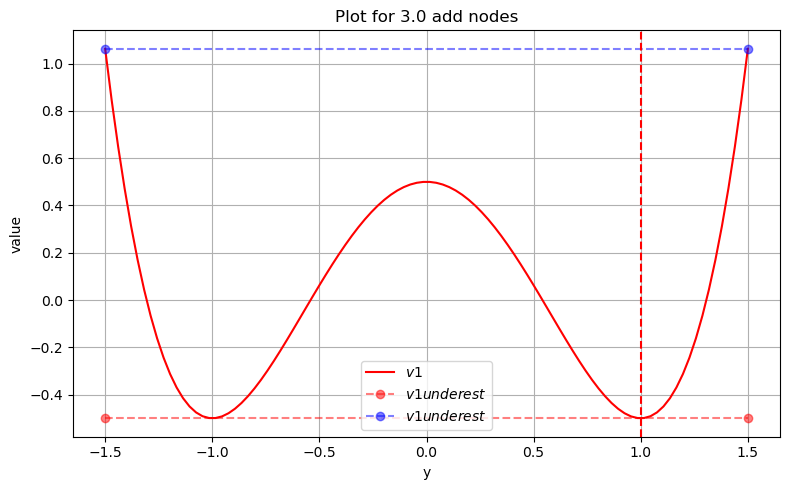

   
   
   
y node is  [-1.5         1.00320513  1.5       ]
y node length 3
ms value is  [-1.2731060072217177, -1.2731060072217177]
new_nodes is  -1.0704116623829767
this time choose scenario  1


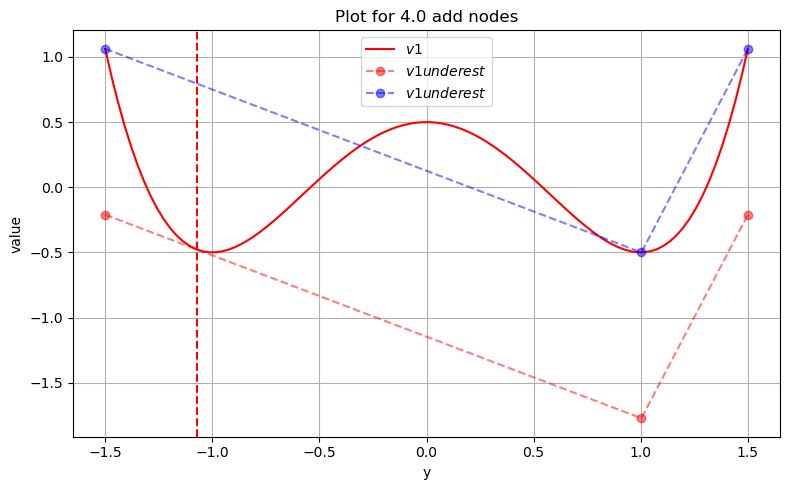

   
   
   
y node is  [-1.5        -1.07041166  1.00320513  1.5       ]
y node length 4
ms value is  [-0.4635179408437191, -0.4635179408437191]
new_nodes is  1.2720460834773755
this time choose scenario  2


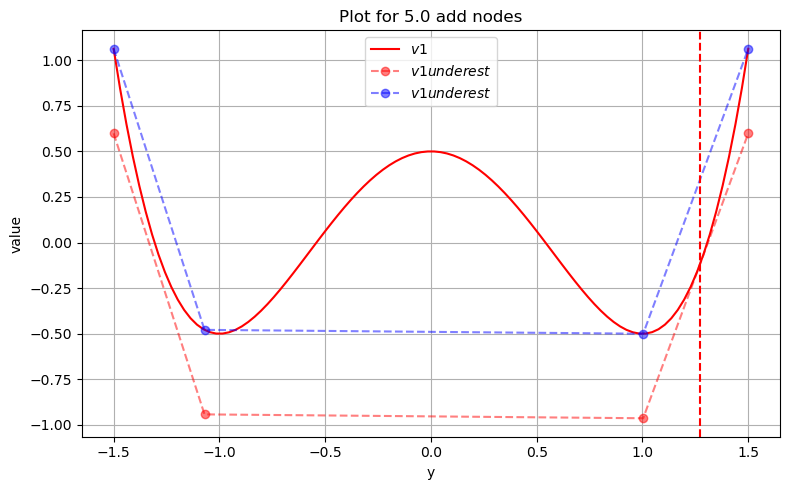

   
   
   
y node is  [-1.5        -1.07041166  1.00320513  1.27204608  1.5       ]
y node length 5
ms value is  [-0.3688535848272618, -0.3688535848272618]
new_nodes is  -1.299983543129783
this time choose scenario  3


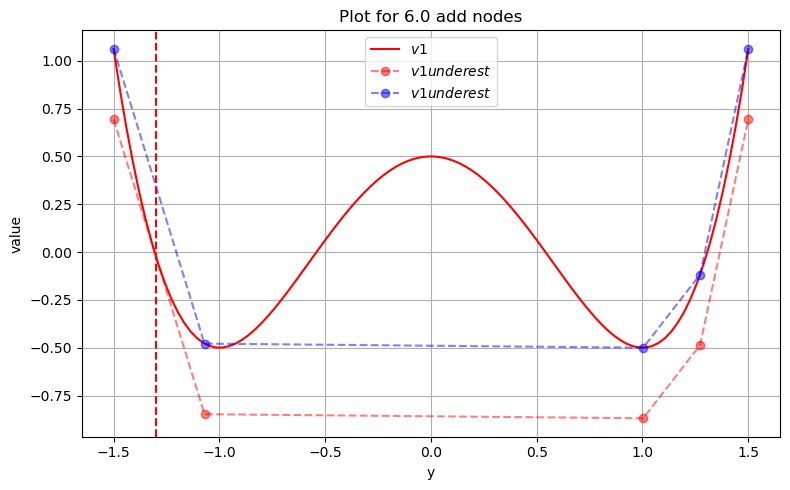

   
   
   
y node is  [-1.5        -1.29998354 -1.07041166  1.00320513  1.27204608  1.5       ]
y node length 6
ms value is  [-0.12405911052166413, -0.12405911052166413]
new_nodes is  1.3897923308291613
this time choose scenario  4


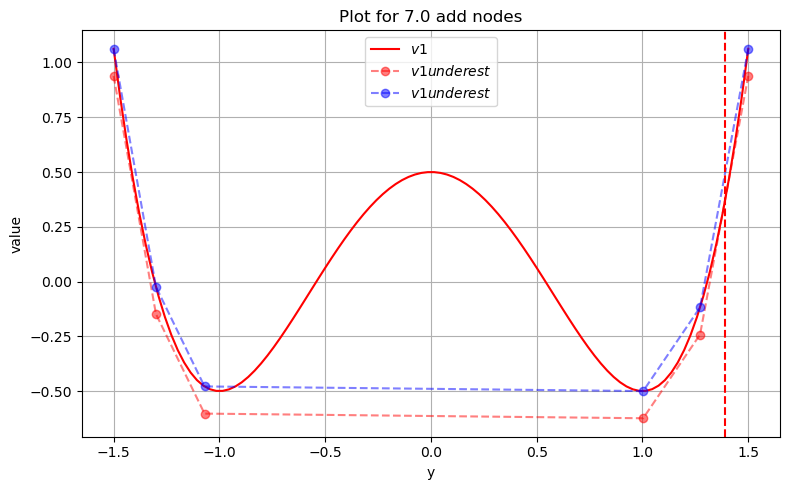

   
   
   
y node is  [-1.5        -1.29998354 -1.07041166  1.00320513  1.27204608  1.38979233
  1.5       ]
y node length 7
ms value is  [-0.10478768641310399, -0.10478768641310399]
new_nodes is  1.144578316257184
this time choose scenario  5


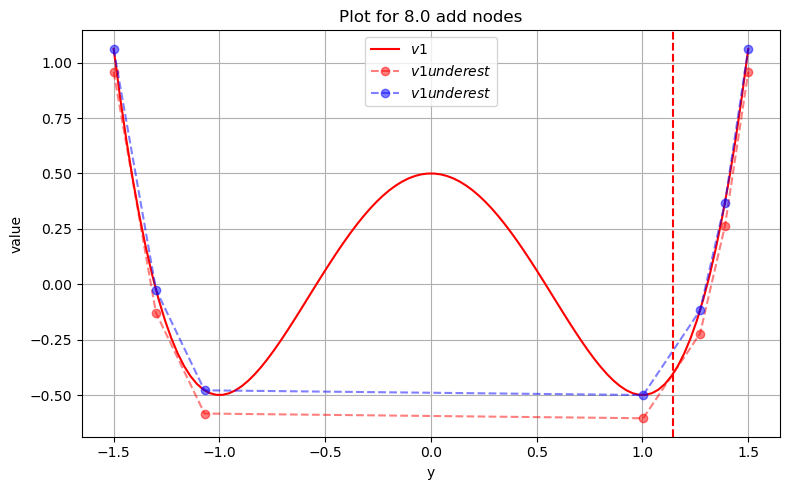

   
   
   
y node is  [-1.5        -1.29998354 -1.07041166  1.00320513  1.14457832  1.27204608
  1.38979233  1.5       ]
y node length 8
ms value is  [-0.09779493551599383, -0.09779493551599383]
new_nodes is  -1.4028540639474067
this time choose scenario  6


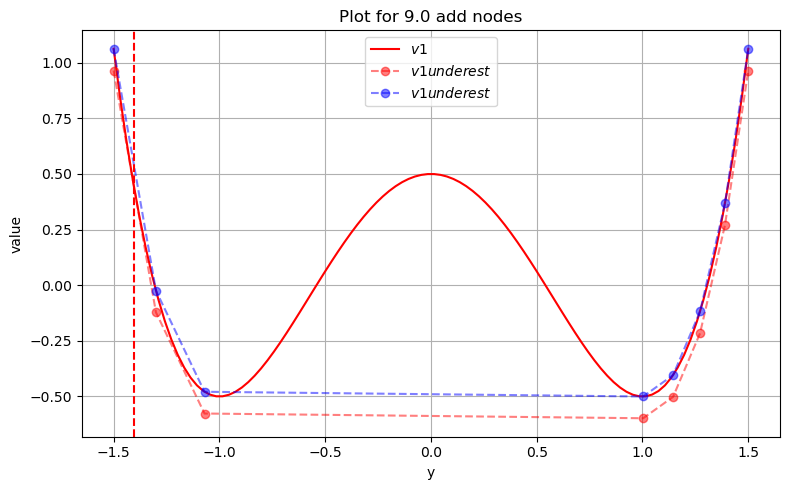

In [67]:
for i in range(len(results)):
    # y and z = |y|
    y_vals = np.linspace(ylb, yub, 100)
    Qs_vals1 = [v_list[0](y) for y in y_vals]
    Qs_vals2 = [v_list[1](y) for y in y_vals]
    Qs_vals_sum = [v_list[0](y)+v_list[1](y) for y in y_vals]

    # As(y)
    y_nodes = np.array(results[i][2])
    as_nodes1 = np.array(results[i][3])
    as_nodes2 = np.array(results[i][5])
    bbb1 = np.array(as_nodes1)
    bbb2 = np.array(as_nodes2)
    bbb_sum = bbb1+bbb2
    ms1 = results[i][4]
    ms2 = results[i][6]
    #err = -results[i][1]
    err = ms1+ms2
    
    print("   ")
    print("   ")
    print("   ")
    #print('effective add node num ',results[i][-2])
    print('y node is ',y_nodes)
    print('y node length',len(y_nodes))
    print("ms value is ",[results[i][4],results[i][6]])
    print("new_nodes is ",results[i][-1])
    print("this time choose scenario ",results[i][-2])

    # make the plot
    
    plt.figure(figsize=(8, 5))
    
    plt.plot(y_vals, Qs_vals1, label=r'$v1$', color='red')
    plt.plot(y_nodes, bbb1+ms1,label=r'$v1 underest$',color='red', marker='o',linestyle='--',alpha=0.5)
    plt.plot(y_nodes, bbb1,label=r'$v1 underest$',color='blue', marker='o',linestyle='--',alpha=0.5)
    
    '''
    plt.plot(y_vals, Qs_vals2, label=r'$v2$', color='blue')
    plt.plot(y_nodes, bbb2+ms2,label=r'$v2 underest$',color='blue', marker='o',linestyle='--',alpha=0.5)
    
    plt.plot(y_vals, Qs_vals_sum, label=r'$v_sum$', color='black')
    plt.plot(y_nodes, bbb_sum+err,label=r'$v_sum underest$',color='black', marker='o',linestyle='--',alpha=0.5)
    '''
    plt.axvline(x=results[i][-1], color='red', linestyle='--')
    #plt.hlines(y=mmm, xmin=ylb, xmax=yub,color='red', linestyle='--')
    
    #plt.xlim(0.05, 0.125)
    #plt.ylim(-0.4, -0.2)
    plt.xlabel('y')
    plt.ylabel('value')
    plt.title(f"Plot for {adds[i]:.1f} add nodes")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [20]:
# build function for each scenario
def v_1(y):  
    return - np.sqrt(np.abs(y))

def v_2(y): 
    return np.sqrt(np.abs(y))

v_list = [v_1, v_2]

# build model for each scenario 
m1 = ConcreteModel()
m1.y = Var(bounds=(-1, 1))
m1.x1 = Var(bounds=(0, 1))
m1.x11 = Var(bounds=(0, None))
m1.c1 = Constraint(expr=m1.x11**2 == m1.y**2)
m1.c2 = Constraint(expr=m1.x11 == (m1.x1)**2)
m1.obj_expr = Expression(expr=-m1.x1)

m2 = ConcreteModel()
m2.y = Var(bounds=(-1, 1))
m2.x1 = Var(bounds=(0, 1))
m2.x11 = Var(bounds=(0, None))
m2.c1 = Constraint(expr=m2.x11**2 == m2.y**2)
m2.c2 = Constraint(expr=m2.x11 == (m2.x1)**2)
m2.obj_expr = Expression(expr=-m2.x1)

model_list = [m1]
# lower bound and upper bound
ylb = -0.2
yub = 0.2
bounds = [ylb, yub]

In [21]:
# make delta list
adds = np.arange(3, 8)
results = [nc_underest([ylb, yub],[m1,m2],a) for a in adds]

start
Start adding node  2
Solving scenario  0
Solving scenario  1
 
 
error is  0.8944271909999159
ms is  [0.0, 0.0] 0.0
 
 
new node choosen from error
 
new node is 0.0
ms list is [0.0, 0.0]
y_nodes is [-0.2, 0.0, 0.2]
Start adding node  3
Solving scenario  0
Solving scenario  1
 
 
error is  0.22360681067697585
ms is  [-0.11180340533848798, -0.11180340533848798] 0.22360681067697596
 
 
new node choosen from ms
 
new node is -0.04998092776511266
ms list is [-0.11180340533848798, -0.11180340533848798]
y_nodes is [-0.2, 0.0, 0.2]
start
Start adding node  2
Solving scenario  0
Solving scenario  1
 
 
error is  0.8944271909999159
ms is  [0.0, 0.0] 0.0
 
 
new node choosen from error
 
new node is 0.0
ms list is [0.0, 0.0]
y_nodes is [-0.2, 0.0, 0.2]
Start adding node  3
Solving scenario  0
Solving scenario  1
 
 
error is  0.22360681067697585
ms is  [-0.11180340533848798, -0.11180340533848798] 0.22360681067697596
 
 
new node choosen from ms
 
new node is -0.04998092776511266
ms list is

   
   
   
y node is  [-0.2  0.   0.2]
y node length 3
ms value is  [-0.11180340533848798, -0.11180340533848798]
new_nodes is  -0.04998092776511266
this time choose scenario  1


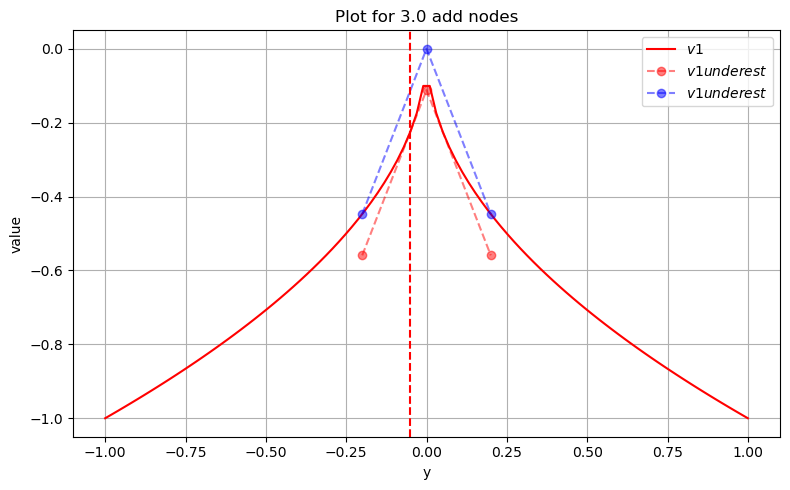

   
   
   
y node is  [-0.2        -0.04998093  0.          0.2       ]
y node length 4
ms value is  [-0.1118033669886418, -0.1118033669886418]
new_nodes is  0.04994661012497079
this time choose scenario  2


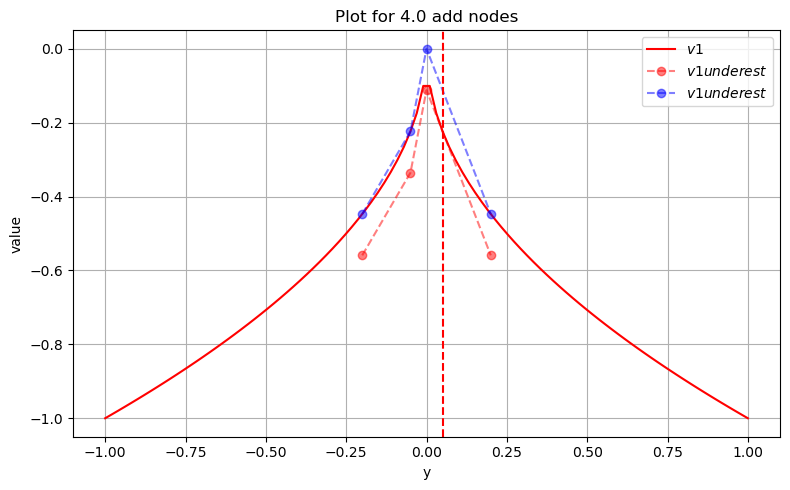

   
   
   
y node is  [-0.2        -0.04998093  0.          0.04994661  0.2       ]
y node length 5
ms value is  [-0.05589099986318791, -0.05589099986318791]
new_nodes is  -0.2
this time choose scenario  3


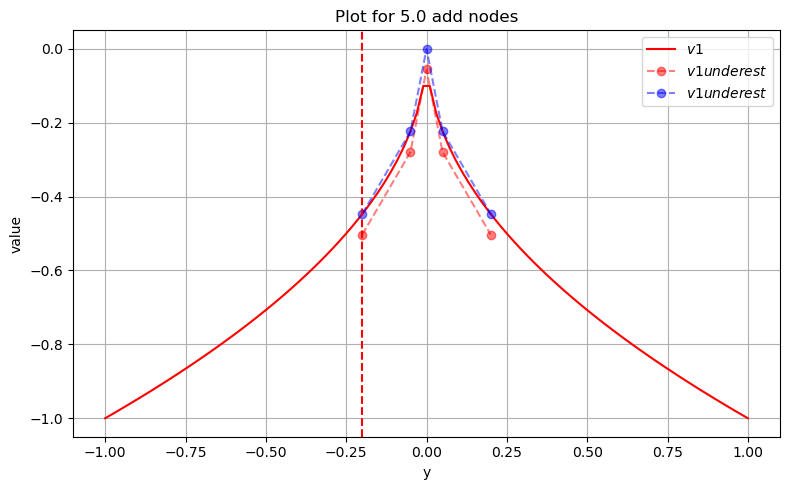

   
   
   
y node is  [-0.2        -0.04998093  0.          0.04994661  0.2       ]
y node length 5
ms value is  [-0.05589099986318791, -0.05589099986318791]
new_nodes is  -0.2
this time choose scenario  3


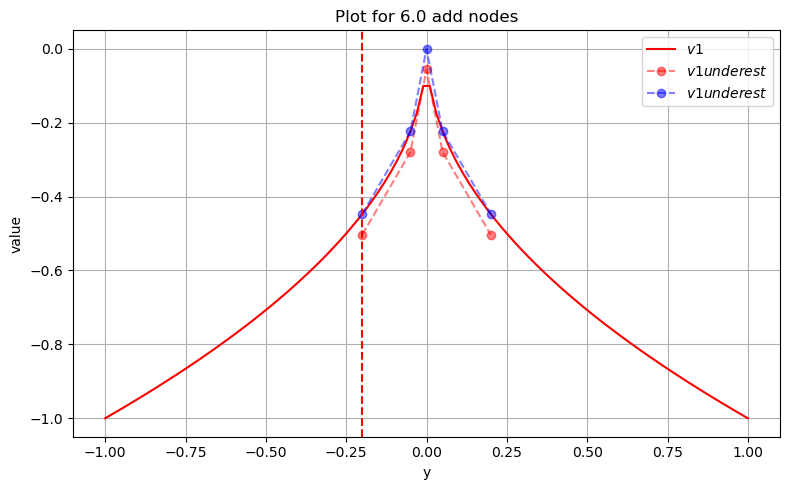

   
   
   
y node is  [-0.2        -0.04998093  0.          0.04994661  0.2       ]
y node length 5
ms value is  [-0.05589099986318791, -0.05589099986318791]
new_nodes is  -0.2
this time choose scenario  3


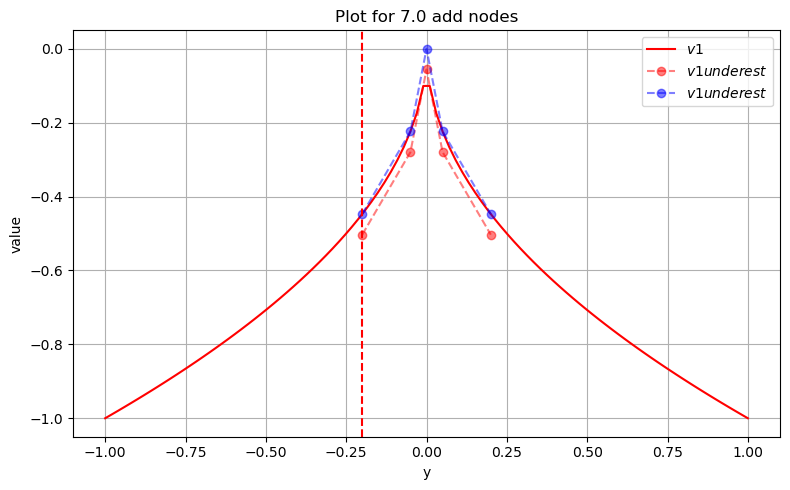

In [26]:
for i in range(len(results)):
    # y and z = |y|
    y_vals = np.linspace(ylb, yub, 100)
    Qs_vals1 = [v_list[0](y) for y in y_vals]
    Qs_vals2 = [v_list[1](y) for y in y_vals]
    Qs_vals_sum = [v_list[0](y)+v_list[1](y) for y in y_vals]

    # As(y)
    y_nodes = np.array(results[i][2])
    as_nodes1 = np.array(results[i][3])
    as_nodes2 = np.array(results[i][5])
    bbb1 = np.array(as_nodes1)
    bbb2 = np.array(as_nodes2)
    bbb_sum = bbb1+bbb2
    ms1 = results[i][4]
    ms2 = results[i][6]
    #err = -results[i][1]
    err = ms1+ms2
    
    print("   ")
    print("   ")
    print("   ")
    #print('effective add node num ',results[i][-2])
    print('y node is ',y_nodes)
    print('y node length',len(y_nodes))
    print("ms value is ",[results[i][4],results[i][6]])
    print("new_nodes is ",results[i][-1])
    print("this time choose scenario ",results[i][-2])

    # make the plot
    
    plt.figure(figsize=(8, 5))
    
    plt.plot(y_vals, Qs_vals1, label=r'$v1$', color='red')
    plt.plot(y_nodes, bbb1+ms1,label=r'$v1 underest$',color='red', marker='o',linestyle='--',alpha=0.5)
    plt.plot(y_nodes, bbb1,label=r'$v1 underest$',color='blue', marker='o',linestyle='--',alpha=0.5)
    
    '''
    plt.plot(y_vals, Qs_vals2, label=r'$v2$', color='blue')
    plt.plot(y_nodes, bbb2+ms2,label=r'$v2 underest$',color='blue', marker='o',linestyle='--',alpha=0.5)
    
    plt.plot(y_vals, Qs_vals_sum, label=r'$v_sum$', color='black')
    plt.plot(y_nodes, bbb_sum+err,label=r'$v_sum underest$',color='black', marker='o',linestyle='--',alpha=0.5)
    '''
    plt.axvline(x=results[i][-1], color='red', linestyle='--')
    #plt.hlines(y=mmm, xmin=ylb, xmax=yub,color='red', linestyle='--')
    
    #plt.xlim(0.05, 0.125)
    #plt.ylim(-0.4, -0.2)
    plt.xlabel('y')
    plt.ylabel('value')
    plt.title(f"Plot for {adds[i]:.1f} add nodes")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [11]:
y_nodes = [-1, 1]
assum_nodes = [0,0]

model_sum = ConcreteModel()
model_sum.y = Var(bounds=(-1, 1))
model_sum.As = Var()
model_sum.pw = Piecewise(
    model_sum.As, model_sum.y,
    pw_pts=y_nodes,
    f_rule=list(assum_nodes),
    pw_constr_type='EQ',
    pw_repn='SOS2'
)
eps = 1e-6
model_sum.obj = Objective(expr = model_sum.As, sense=minimize)
results = solver.solve(model_sum)


y_star = value(model_sum.y, exception=False)   
if y_star is None:
    y_star = 0.5*(lb + ub)
print(y_star)

NameError: name 'lb' is not defined

In [33]:
solver = SolverFactory('gurobi')
solver.options['FeasibilityTol'] = 1e-9
solver.options['OptimalityTol'] = 1e-9
solver.options['NonConvex'] = 2 

In [61]:
y_nodes = [-0.5,-0.1,0,0.5,1]
assum_nodes = [-1,-1,-1,-1,0]

model_sum = ConcreteModel()
model_sum.y = Var(bounds=(-1, 1))
model_sum.As = Var()
model_sum.pw = Piecewise(
    model_sum.As, model_sum.y,
    pw_pts=y_nodes,
    f_rule=list(assum_nodes),
    pw_constr_type='EQ',
    pw_repn='SOS2'
)
model_sum.obj = Objective(expr = model_sum.As, sense=minimize)
results = solver.solve(model_sum)
y_star = value(model_sum.y)
print(y_star)

**WARNING: Piecewise 'pw[None]' feasible region does not include the lower bound of domain variable: y.lb = -1 < -0.5. Refer to the Piecewise help documentation for information on how to disable this warning.
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
-0.1


In [34]:
y_nodes = [-1, -0.5, 0.5, 1]
assum_nodes = [0,-1,-1,0]

model_sum = ConcreteModel()
model_sum.y = Var(bounds=(-1, 1))
model_sum.As = Var()
model_sum.pw = Piecewise(
    model_sum.As, model_sum.y,
    pw_pts=y_nodes,
    f_rule=list(assum_nodes),
    pw_constr_type='EQ',
    pw_repn='SOS2'
)
eps = 1e-6
model_sum.obj = Objective(expr = model_sum.As + eps*model_sum.y**2, sense=minimize)
results = solver.solve(model_sum)
y_star = value(model_sum.y)
print(y_star)

0.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


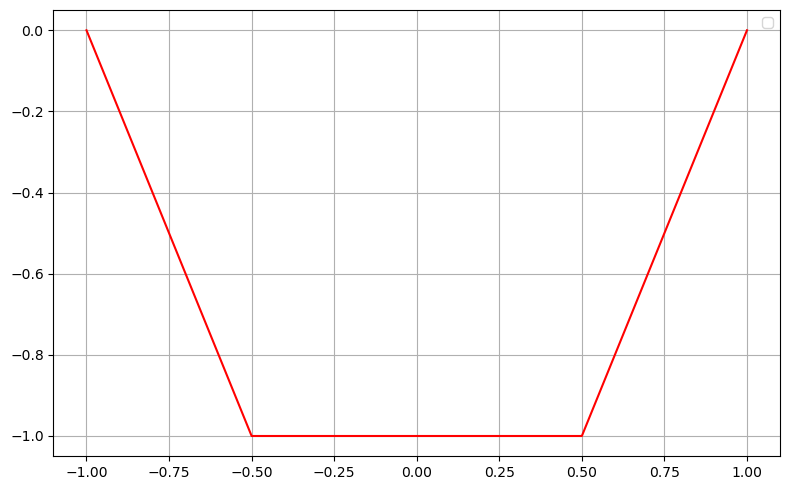

In [100]:
plt.figure(figsize=(8, 5))
plt.plot(y_nodes, assum_nodes, color='red')

plt.legend()
plt.grid(True)
plt.tight_layout()

In [82]:
import pyomo.environ as pyo
from pyomo.environ import ConcreteModel, Var, Objective, Piecewise, minimize, value
from pyomo.opt import SolverFactory

# 倒梯形分段
y_nodes = [-1.0, -0.5, 0.0, 0.5, 1.0]
f_nodes =  [ 0.0, -1.0, -1.0,-1.0, 0.0]

m = ConcreteModel()
m.y  = Var(bounds=(-1, 1))
m.fy = Var()  # piecewise 输出

m.pw = Piecewise(
    m.fy, m.y,
    pw_pts=y_nodes,
    f_rule=list(f_nodes),
    pw_constr_type='EQ',
    pw_repn='SOS2',
    warn_consec_slope=False
)

# 极小的二级目标系数：只起到打破平局作用
eps = 1e-6
m.obj = Objective(expr = m.fy + eps*m.y**2, sense=minimize)

opt = SolverFactory('gurobi')
opt.options['Threads'] = 1      # 让结果可复现
res = opt.solve(m, tee=False)

print('y* =', value(m.y))       # -> 0.0（在底边内部）
print('f(y*) =', value(m.fy))   # -> -1.0

ValueError: Unexpected keyword options found while constructing 'SimplePiecewise':
	warn_consec_slope

In [83]:
m = ConcreteModel()
m.y  = Var(bounds=(-1, 1))
m.fy = Var()
m.t  = Var(bounds=(0, None))  # |y| 的上界变量

m.pw = Piecewise(
    m.fy, m.y,
    pw_pts=y_nodes, f_rule=list(f_nodes),
    pw_constr_type='EQ', pw_repn='SOS2',
    warn_consec_slope=False
)

# 把解限制在底边（函数最小值集合）
m.bottom = pyo.Constraint(expr = m.fy == -1)

# 线性地最小化 |y|： t >= y, t >= -y
m.abs1 = pyo.Constraint(expr = m.t >=  m.y)
m.abs2 = pyo.Constraint(expr = m.t >= -m.y)

m.obj = Objective(expr = m.t, sense=minimize)

opt = SolverFactory('gurobi')
opt.options['Threads'] = 1
res = opt.solve(m, tee=False)

print('y* =', value(m.y))      # -> 0.0
print('f(y*) =', value(m.fy))  # -> -1.0


ValueError: Unexpected keyword options found while constructing 'SimplePiecewise':
	warn_consec_slope